In [1]:
import os
import json
import math
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# NOTE: put this notebook in the same directory as the logs
# Load logs from JSON into list of dictionaries
folderPath = os.path.pardir + '/logs 170928'
files = [os.path.join(folderPath, f) for f in next(os.walk(folderPath))[2]]
print files


['../logs 170928/.DS_Store', '../logs 170928/0', '../logs 170928/10', '../logs 170928/12', '../logs 170928/13', '../logs 170928/14', '../logs 170928/15', '../logs 170928/17', '../logs 170928/18', '../logs 170928/19', '../logs 170928/2', '../logs 170928/20', '../logs 170928/21', '../logs 170928/22', '../logs 170928/3', '../logs 170928/4', '../logs 170928/5', '../logs 170928/6', '../logs 170928/8', '../logs 170928/9']


In [2]:
# Function to extract coorinates as 2 x number of steps array
def get_coords(mouse):
    # Empty array
    coords = np.zeros((2, len(mouse)))

    # Load coordinates into array 
    for i, t in enumerate(mouse):
        # Note that becuase web axis are left-down, we invert the y
        coords[0,i] = t['x']
        coords[1,i] = -t['y']

    # Subtract start from all plints to center at 0,0
    x_start, y_start = coords[0,0], coords[1,0]
    coords -= np.array([[x_start],[y_start]])
    
    # Return our coordinate array
    return coords

In [3]:
# Function to rotate coordinates so start and end are on x-axis
def rot_coords(coords):

    # Get start and end for angle
    x_start, y_start = coords[0,0], coords[1,0]
    x_end, y_end = coords[0,-1], coords[1,-1]

    # Some trig to make rotation matrix... SOHCAHTOA! SOHCAHTOA! SOHCAHTOA!
    r = -math.atan2((y_end-y_start),(x_end-x_start))
    R = np.array([[math.cos(r), -math.sin(r)],[math.sin(r), math.cos(r)]])
    
    # Return the rotated coordiantes and the maximnum absolute y value
    rotated = np.matmul(R, coords)
    max_y = np.abs(rotated[1,:]).max()
    
    return rotated, max_y

In [4]:
# Empty array for all log files
tests = []

# Load in logs
for f in files:
    if os.path.basename(f) not in ['.DS_Store', '.gitignore','mouse_movement.ipynb']:
        with open(f, 'r') as f:
            data = json.load(f)
            tests.append(data)

In [5]:
# Empty arrays to construct our dataframe (or numpy array)
name = []
device = []
image = []
flag = []
action = []
mouse = []
owl = []
all_coords = []

# Loop over every test in logs
for test in tests:
    # Loop over every iamge in logs 
    for img in test['experiment']:
        if img['dataType'] == "trial":
            
            # Load relevant data into array
            name.append(test['name'])
            device.append(test['device'])
            flag.append(img['flag'])
            
            # For images, label sd actual o fake
            if 'not' in img['trialImage']:
                image.append(False)
            else:
                image.append(True)
            
            # For 'owl' or warmup category
            if 'owl' in img['trialImage']:
                owl.append(True)
            else:
                owl.append(False)
            
            # For action
            if img['action'] == 'optionA':
                action.append(True)
            else:
                action.append(False)
                
            # Get maximum deviation in rotated coordinated 
            coords = get_coords(img['mouse'])
            coords2, max_y = rot_coords(coords)
            
            all_coords.append(coords2)
            mouse.append(max_y)

In [6]:
# Function to classify test condition
def classify_condition(df):
    if df.image and df.flag:
        return 'imgT_aiT'
    elif df.image and not df.flag:
        return  'imgT_aiF'
    elif not df.image and df.flag:
        return  'imgF_aiT'
    elif not df.image and not df.flag:
        return  'imgF_aiF'

In [168]:
# Function to classify test condixtion
def classify_condition2(df):
    if df.image and df.flag:
        return 'aligned'
    elif df.image and not df.flag:
        return  'not-aligned'
    elif not df.image and df.flag:
        return  'not-aligned'
    elif not df.image and not df.flag:
        return  'aligned'

In [7]:
# Construct a Pandas dataframe in case we want to do maths
df = pd.DataFrame({'name':name, 'image':image, 'flag':flag, 'action':action, 'mouse':mouse, 'device':device, 'owl':owl})
df.head(n=20)

,action,device,flag,image,mouse,name,owl
0,False,mouse,None,False,234.339093,MDR,True
1,False,mouse,None,False,70.050022,MDR,True
2,False,mouse,None,False,299.203970,MDR,True
3,True,mouse,None,True,344.025017,MDR,True
4,False,mouse,None,False,303.758277,MDR,True
5,True,mouse,None,True,112.358199,MDR,True
6,True,mouse,None,True,193.490120,MDR,True
7,True,mouse,None,True,255.179486,MDR,True
8,False,mouse,None,False,302.242076,MDR,True
9,False,mouse,None,False,413.286973,MDR,True


In [179]:
df['cond'] = df.apply(lambda x: classify_condition(x), axis = 1)
df['cond2'] = df.apply(lambda x: classify_condition2(x), axis = 1)
df.head()

,action,device,flag,image,mouse,name,owl,cond,cond2
0,False,mouse,None,False,234.339093,MDR,True,imgF_aiF,aligned
1,False,mouse,None,False,70.050022,MDR,True,imgF_aiF,aligned
2,False,mouse,None,False,299.203970,MDR,True,imgF_aiF,aligned
3,True,mouse,None,True,344.025017,MDR,True,imgT_aiF,not-aligned
4,False,mouse,None,False,303.758277,MDR,True,imgF_aiF,aligned


In [180]:
df_nowl = df.loc[df.owl == False]
df_nowl.head()

,action,device,flag,image,mouse,name,owl,cond,cond2
10,True,mouse,True,True,373.358636,MDR,False,imgT_aiT,aligned
11,True,mouse,True,True,377.229068,MDR,False,imgT_aiT,aligned
12,True,mouse,True,True,25.612497,MDR,False,imgT_aiT,aligned
13,False,mouse,True,True,159.904923,MDR,False,imgT_aiT,aligned
14,False,mouse,False,False,113.882625,MDR,False,imgF_aiF,aligned


In [181]:
split = df_nowl.groupby(['name', 'cond'])['mouse'].mean()
split_ = split.unstack()
split = split.reset_index()
split_.head()

cond,imgF_aiF,imgF_aiT,imgT_aiF,imgT_aiT
name,,,,
HCS,56.897479,114.001188,58.254485,124.417266
I.W.,147.038094,303.663440,132.815047,110.276143
J.Q,69.779818,198.525469,162.342486,128.133073
JF,168.092094,364.523057,175.125299,199.745079
KS,230.327719,402.735624,16.215102,92.806797


In [18]:
# To CSV
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M_")
df.to_csv(timestamp + 'stacked.csv')
split_.to_csv(timestamp + 'split.csv')

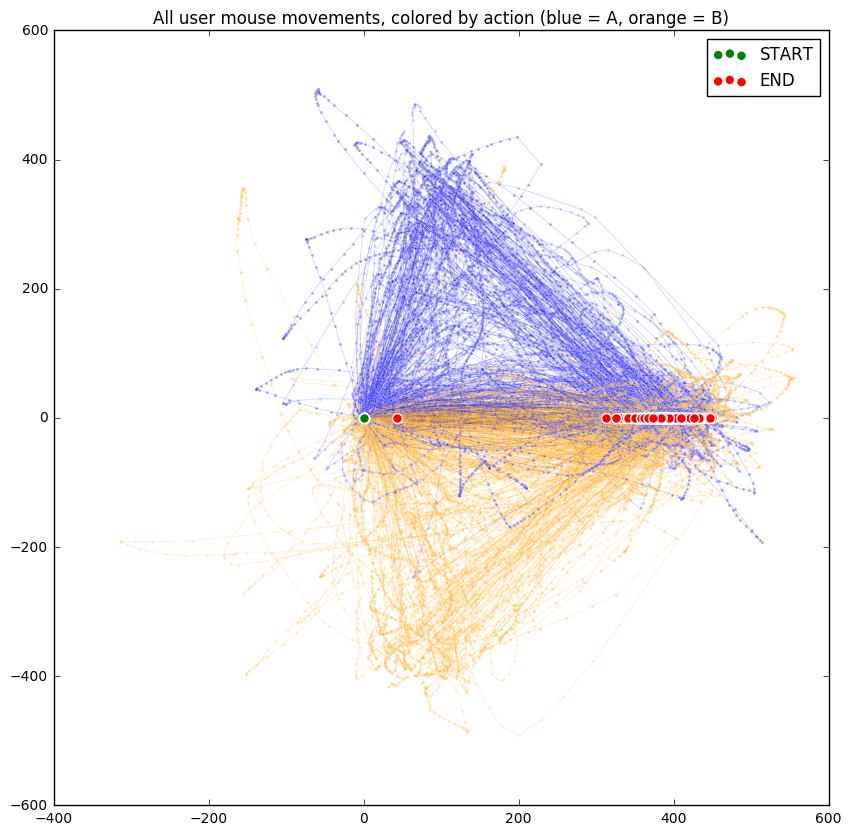

In [16]:
# Plot to check for first user
coords_user = all_coords[:]
color = ['blue', 'orange']
plt.figure(figsize=(10,10))

for i, coords in enumerate(coords_user):
    plt.plot(coords[0,:], coords[1,:] , lw = .5, c = color[action[i]], alpha = 0.2, ms=2, mec='white', marker='o', zorder=1)
    plt.scatter(coords[0,0], coords[1,0], c='green', s=50, lw = 1, edgecolors='white', label='START', zorder=10)
    plt.scatter(coords[0,-1], coords[1,-1], c='red', s=50, lw = 1, edgecolors='white', label='END', zorder=10)
    
    if i == 0:
        plt.legend()

plt.title('All user mouse movements, colored by action (blue = A, orange = B)')

plt.show()



In [182]:
split.head()
# pd.get_dummies(split.cond)

for_bar = split.groupby('cond').mean().reset_index()
std = (split.groupby('cond').std().values)
error = std / np.sqrt(len(split.name.unique()))*1.96

In [185]:
from scipy import stats as st

print st.ttest_ind(split.mouse[split.cond == 'imgF_aiF'], split.mouse[split.cond == 'imgT_aiF'], axis=0, equal_var=True)

Ttest_indResult(statistic=2.530107974741604, pvalue=0.016357081136989079)


In [163]:
split.cond[split.cond == 'imgT_aiT']

3     imgT_aiT
7     imgT_aiT
11    imgT_aiT
15    imgT_aiT
19    imgT_aiT
23    imgT_aiT
27    imgT_aiT
30    imgT_aiT
34    imgT_aiT
36    imgT_aiT
40    imgT_aiT
44    imgT_aiT
48    imgT_aiT
52    imgT_aiT
56    imgT_aiT
60    imgT_aiT
64    imgT_aiT
68    imgT_aiT
Name: cond, dtype: object

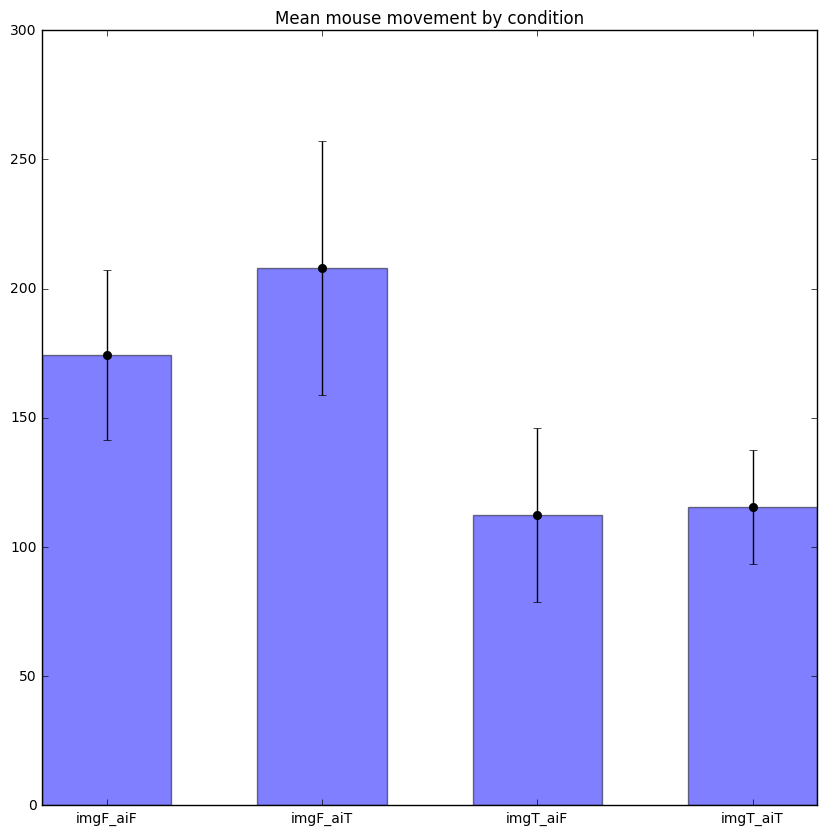

In [145]:
names = for_bar.cond.values
values = for_bar.mouse.values

plt.figure(figsize=(10,10))

plt.bar([0,1,2,3], values, .6, 0, tick_label = names, alpha = 0.5, align = 'center')
plt.errorbar([0,1,2,3], values, yerr=error, fmt='o', c='black')
plt.title('Mean mouse movement by condition')
plt.show()

HCS
I.W.
J.Q
JF
KS
LR
MDR
MDR-touchpad
P
RG
SAW
SH
SM
SR
TM
X to the Z Xzibit 
ssa
vs


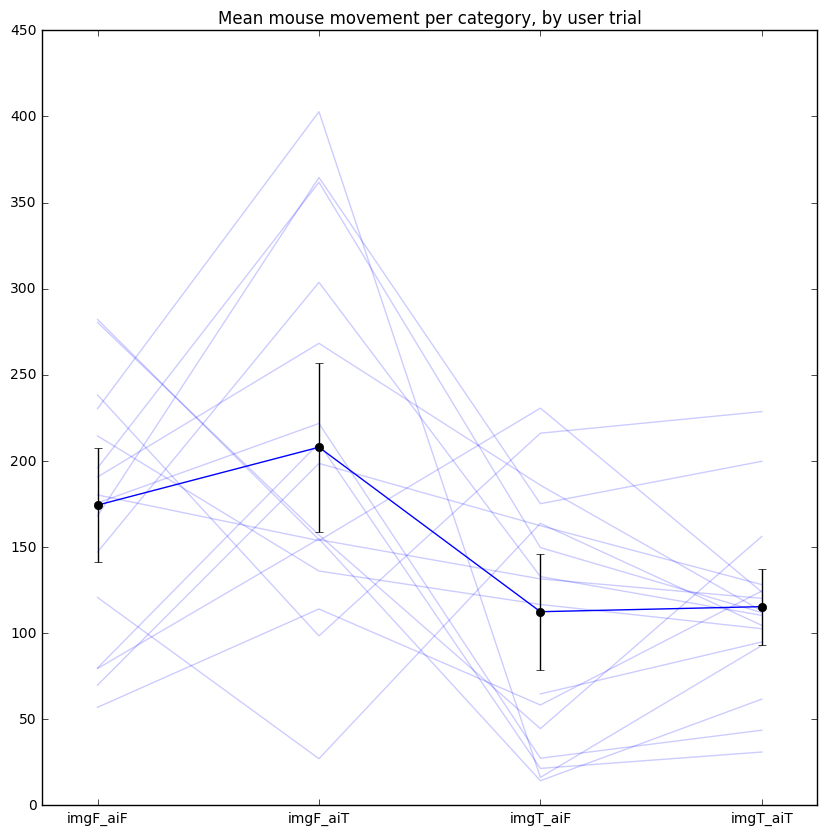

In [148]:

plt.figure(figsize=(10,10))

for i, user in split_.reset_index().iterrows():
    print user[0]
    plt.plot([1,2,3,4], [user[1], user[2], user[3], user[4]], alpha = 0.2, c="blue" )

plt.plot([1,2,3,4], values, c='blue')
plt.errorbar([1,2,3,4], values, yerr=error, fmt='o', c='black')
plt.xlim([.75,4.25])
plt.xticks([1,2,3,4], split_.columns)
plt.title("Mean mouse movement per category, by user trial")
plt.show()


In [134]:
values

array([ 174.30950258,  207.90308329,  112.40680216,  115.35414245])